In [12]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, override

# Initialize wandb
api = wandb.Api(overrides={"entity":"mmtftr-bo-azi-i-niversitesi"})

# Get runs from your project
runs = api.runs("go-embedding-evaluation-v2")  # Replace with your actual project name
runs = [(run.config, run.history()) for run in runs]


In [18]:

# Collect data
data = []
for config, history in runs:
    # Get the last logged metrics
    if not history.empty:
        # Extract metrics for each embedding type and model
        for _, metrics in history.iterrows():
            metrics_dict = metrics.to_dict()
            for key, value in metrics_dict.items():
                if isinstance(value, (int, float)):  # Filter out non-numeric values
                    # Parse the metric key (format: "base_ontology/embedding_type/model/metric")
                    parts = key.split('/')
                    if len(parts) == 4:
                        base_ontology, embedding_type, model, metric = parts
                        if model == 'MLPClassifier' and metric in ["MRR", "Hits@1", "Hits@5", "Hits@10"]:
                            data.append({
                                'base_ontology': config.get('base_ontology', 'unknown'),
                                'embedding_type': embedding_type,
                                'model': model,
                                'metric': metric,
                                'value': value
                            })
# Convert to DataFrame
df = pd.DataFrame(data)

# Create summary table
summary_table = df.pivot_table(
    index=['base_ontology', 'embedding_type', 'model'],
    columns='metric',
    values='value',
    aggfunc='last',
    sort=True,
).sort_values(by=['base_ontology', 'MRR'], ascending=False).round(3)

# Display the table
from IPython.display import display
display(summary_table)


metric                                       Hits@1  Hits@10  Hits@5    MRR
base_ontology embedding_type  model                                        
go-full       anc2vec         MLPClassifier   0.077    0.365   0.245  0.170
              owl2vec         MLPClassifier   0.071    0.343   0.230  0.158
              anc2vec-sbert   MLPClassifier   0.069    0.328   0.217  0.152
              anc2vec-sbert-2 MLPClassifier   0.063    0.333   0.220  0.149
              sbert           MLPClassifier   0.060    0.297   0.190  0.137
              biobert         MLPClassifier   0.008    0.112   0.058  0.047
go-basic      anc2vec         MLPClassifier   0.092    0.414   0.290  0.196
              anc2vec-sbert   MLPClassifier   0.076    0.335   0.232  0.161
              anc2vec-sbert-2 MLPClassifier   0.069    0.340   0.233  0.157
              owl2vec         MLPClassifier   0.066    0.333   0.221  0.152
              sbert           MLPClassifier   0.054    0.292   0.188  0.131
              biobert         MLPClassifier   0.022    0.156   0.097  0.071
              gt2vec          MLPClassifier   0.006    0.067   0.028  0.038

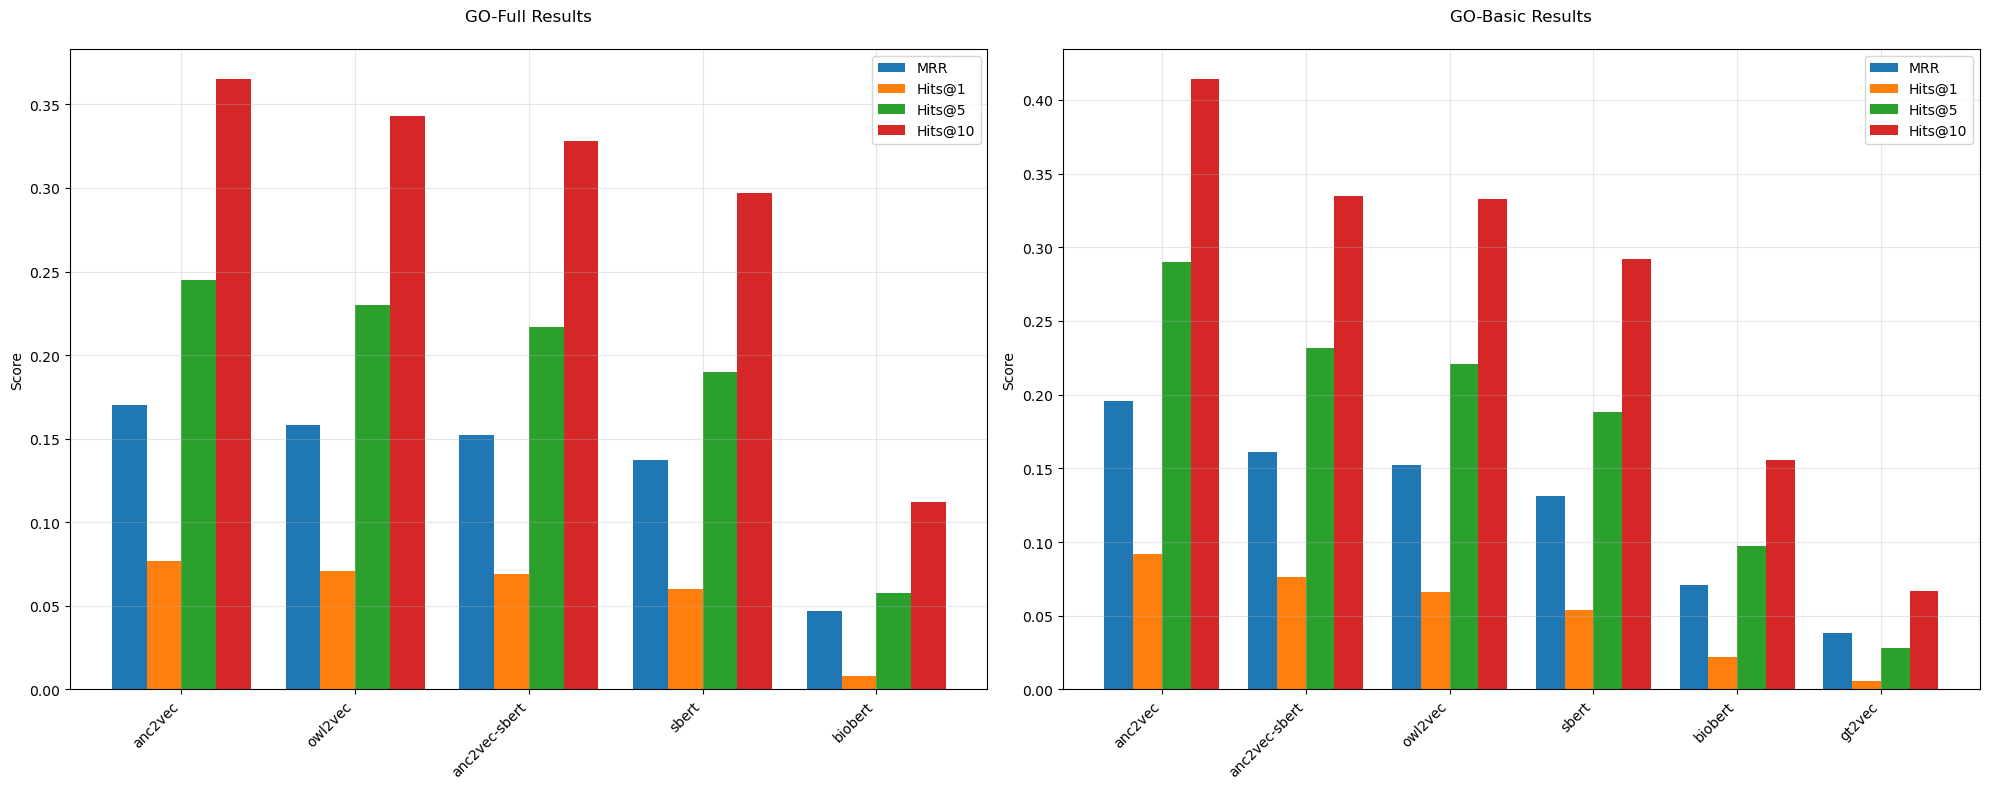

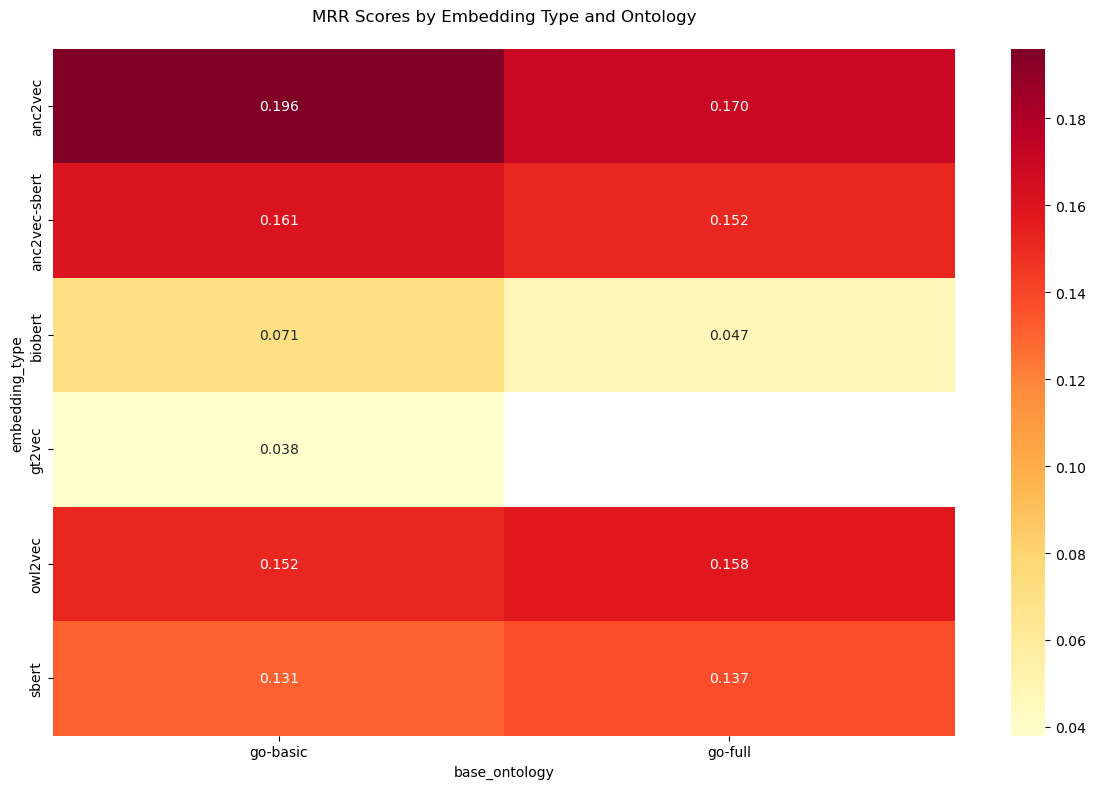

In [9]:
# Reset the index to make the data easier to plot
plot_df = summary_table.reset_index()

# Create figure and axes with larger figsize
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for go-full
go_full_data = plot_df[plot_df['base_ontology'] == 'go-full']
x = np.arange(len(go_full_data['embedding_type'].unique()))
width = 0.2

for i, metric in enumerate(['MRR', 'Hits@1', 'Hits@5', 'Hits@10']):
    axes[0].bar(x + i*width, go_full_data[metric], width, label=metric)

axes[0].set_ylabel('Score')
axes[0].set_title('GO-Full Results', pad=20)
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(go_full_data['embedding_type'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot for go-basic
go_basic_data = plot_df[plot_df['base_ontology'] == 'go-basic']
x = np.arange(len(go_basic_data['embedding_type'].unique()))

for i, metric in enumerate(['MRR', 'Hits@1', 'Hits@5', 'Hits@10']):
    axes[1].bar(x + i*width, go_basic_data[metric], width, label=metric)

axes[1].set_ylabel('Score')
axes[1].set_title('GO-Basic Results', pad=20)
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(go_basic_data['embedding_type'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create heatmap
plt.figure(figsize=(12, 8))
pivot = plot_df.pivot(index='embedding_type', columns='base_ontology', values='MRR')
sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('MRR Scores by Embedding Type and Ontology', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
#original paper results: owl2vec -> .     0.064    -       -      0.152

In [9]:
import numba
import numpy as np
from numba import typed

# Sample data setup
all_classes = np.random.randint(0, 10000, 10000)

@numba.njit
def filter_classes(all_classes, ancestors):
    """
    Create a boolean mask for filtering classes

    Args:
        all_classes: Array of all class IDs
        ancestors: Array of ancestor class IDs to filter out

    Returns:
        Boolean mask where True indicates class should be kept
    """
    mask = np.ones(len(all_classes), dtype=numba.bool_)

    # Numba-friendly loop for checking membership
    for i in range(len(all_classes)):
        for j in range(len(ancestors)):
            if all_classes[i] == ancestors[j]:
                mask[i] = False
                break
    return mask

def numpy_filter(all_classes, ancestors):
    """
    NumPy version for comparison
    """
    return ~np.isin(all_classes, ancestors)

# Setup test data
sub_id = 100
ancestors = np.random.randint(0, 10000, 100)

# Benchmark
%timeit filter_classes(all_classes, ancestors)
%timeit numpy_filter(all_classes, ancestors)

320 μs ± 4.56 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


KeyboardInterrupt: 

In [49]:

from re import A


valid_classes = np.random.randint(0, 10000, 1000)
gt_id = valid_classes[0]
sorted_indices = np.argsort(valid_classes)[::-1]

@numba.njit()
def calculate_metrics(gt_id, valid_classes, sorted_indices):
    # Find rank of ground truth
    gt_rank = np.where(valid_classes[sorted_indices] == gt_id)[0][0] + 1

    # Calculate hits metrics
    hits1 = gt_id == valid_classes[sorted_indices[0]]
    hits5 = gt_id in valid_classes[sorted_indices[:5]]
    hits10 = gt_id in valid_classes[sorted_indices[:10]]

    return 1.0/gt_rank, hits1, hits5, hits10

def numpy_calculate_metrics(gt_id, valid_classes, sorted_indices):
    # Find rank of ground truth
    gt_rank = np.where(valid_classes[sorted_indices] == gt_id)[0][0] + 1
    return 1.0/gt_rank, gt_id == valid_classes[sorted_indices[0]], gt_id in valid_classes[sorted_indices[:5]], gt_id in valid_classes[sorted_indices[:10]]

@numba.njit()
def calculate_metrics_2(gt_id, valid_classes, sorted_indices):
    # Find position of ground truth in valid_classes
    gt_pos = -1
    for i, idx in enumerate(sorted_indices):
        if valid_classes[idx] == gt_id:
            gt_pos = i
            break

    if gt_pos == -1:
        return 0.0, False, False, False

    # Calculate metrics
    gt_rank = gt_pos + 1
    hits1 = gt_pos == 0
    hits5 = gt_pos < 5
    hits10 = gt_pos < 10

    return 1.0/gt_rank, hits1, hits5, hits10


# %timeit calculate_metrics(gt_id, valid_classes, sorted_indices)
# %timeit calculate_metrics_2(gt_id, valid_classes, sorted_indices)
# %timeit numpy_calculate_metrics(gt_id, valid_classes, sorted_indices)

for cls in valid_classes:
    assert np.allclose(calculate_metrics(cls, valid_classes, sorted_indices), calculate_metrics_2(cls, valid_classes, sorted_indices))
    assert np.allclose(calculate_metrics(cls, valid_classes, sorted_indices), numpy_calculate_metrics(cls, valid_classes, sorted_indices))


AssertionError: 

In [16]:
from rdflib import Graph, RDFS, OWL
import rdflib

# Load Gene Ontology
g = Graph()
g.parse("go-basic.owl")

# Query for all classes that have no subclasses (leaf nodes)
q = """
SELECT (COUNT(DISTINCT ?class) as ?count)
WHERE {
    ?class a owl:Class .
    FILTER NOT EXISTS {
        ?subclass rdfs:subClassOf ?class .
        ?subclass a owl:Class .
        FILTER(?subclass != ?class)
    }
    FILTER(!isBlank(?class))
}
"""

# Execute query and get result
result = g.query(q)
leaf_count = result.bindings[0]['count'].value

print(f"Number of leaf nodes in Gene Ontology: {leaf_count}")


In [15]:
result.bindings



[]

In [64]:
@numba.njit(parallel=True)
def prep_input(sub_v, all_class_v, input_type):
    if input_type == 'concatenate':
        # Create repeated sub_v array
        repeated_sub = np.empty((len(all_class_v), len(sub_v) * 2))
        for i in range(len(all_class_v)):
            repeated_sub[i, :len(sub_v)] = sub_v
            repeated_sub[i, len(sub_v):] = all_class_v[i]

        return repeated_sub
    else:
        # Create repeated sub_v array and subtract
        repeated_sub = np.empty((len(all_class_v), len(sub_v)))
        for i in range(len(all_class_v)):
            repeated_sub[i] = sub_v
        return repeated_sub - all_class_v

def numpy_prep_input(sub_v, all_class_v, input_type):
    if input_type == 'concatenate':
        return np.concatenate([np.repeat(sub_v[None, :], len(all_class_v), axis=0), all_class_v], axis=1)
    else:
        return np.repeat(sub_v[None, :], len(all_class_v), axis=0) - all_class_v

sub_v = np.random.randn(768)
all_class_v = np.random.randn(40000, 768)
input_type = 'concatenate'

%timeit prep_input(sub_v, all_class_v, input_type)
%timeit numpy_prep_input(sub_v, all_class_v, input_type)

6.21 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
105 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
